In [1]:
import numpy as np
import time

import matplotlib.pyplot as plt

$\frac{1}{4}x_i^{4} + \frac{1}{2}x_i^{2} -x_i$

In [2]:
# def f(x):
#     '''
#     1/4 * x^4 + 1/2 * x^2 - x 
#     '''
#     f = np.zeros(len(x))
#     for i in range(len(x)):
#         f[i] = np.power(x[i], 4)/4 + np.power(x[i], 2)/2 - x[i]
#     return f

f = lambda x: (1/4)*np.power(x, 4) + (1/2)*np.power(x,2) - x #function


def delta_f(x, method = 'e', k = 10):
    '''
    method: default='e'
        e : exact derivative,
        f : forward differences,
        b : backward differences,
        c : centered differences
    k: default=10, value for increment h; is ignored when method='e'
    
    Exact gradient function:
        x^3 + x - 1 
    
    Forward differences:
        (f(x+h) - f(x)) / h

    Backward differences:
        (f(x) - f(x-h)) / h

    Centered differences:
        (f(x+h) - f(x-h)) / 2h
    
    where h = 10^-k norm(x)
    '''
        
    if method == 'e': 
        return np.power(x, 3) + x - 1
    else:
        ga = np.zeros(len(x))
        h = 10**(-k) * np.linalg.norm(x)
        
        if method =='f':
            for i in range(len(x)):
                ga[i] = (f(x[i]+h) - f(x[i])) / h
            return ga   
        elif method =='b':
            for i in range(len(x)):
                ga[i] = (f(x[i]) - f(x[i]-h)) / h
            return ga
        elif method =='c':
            for i in range(len(x)):
                ga[i] = (f(x[i]+h) - f(x[i]-h)) / (2*h)
            return ga   

def project(y, L, U):
    p = np.zeros(len(y))
    for i in range(len(y)):
        if y[i]<L[i]: 
            p[i] = L[i]
        elif y[i]>U[i]:
            p[i] = U[i]
        else:
            p[i] = y[i]
    return p

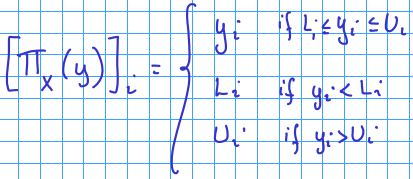

In [3]:
def descent(x0, L, U, kmax = 300, tollgrad = 10**(-4), alpha = 0.3, gamma = 0.1, grad_method = 'e', grad_method_k = 10):
    '''
    x0: initial points for x
    L: lower bound
    U: upper bound
    kmax: max iteration
    tollgrad: tolerance for gradient
    alpha: default=0.31, initial alpha
    gamma: default=0.1
    grad_method: default='e'
        e : exact derivative,
        f : forward differences,
        b : backward differences,
        c : centered differences
    grad_method_k: default=10, value for increment h; is ignored when method='e'
    '''
       
    x = np.zeros((len(x0), kmax+1)) # kmax+1 because we need to also consider x[k+1] case later on
    x[:, 0] = x0
    
#     p_k = -delta_f(x0, method = grad_method, k = grad_method_k)

    
    delta_fk_norm = np.linalg.norm(delta_f(x0, method = grad_method, k = grad_method_k))

    k = 0
    
    # constants for line search algorithm
    rho = 0.35
    jmax = 30
    c1_arm = 10**(-5)
    
    gamma_k = gamma
    alpha_k = 1

    p_k = -delta_f(x[:, 0], method = grad_method, k = grad_method_k)
    
    s = time.time()
    while(k < kmax and delta_fk_norm >= tollgrad):

#         print(p_k)
        x_k_hat = project(x[:, k] - gamma_k * (-p_k), L, U)

        # Find alpha using line search(backtracking method) with respect to the Armijo condition
        j = 0
        while (j < jmax and
               (f(x[:, k] + alpha_k * (x_k_hat-x[:, k])) - f(x[:, k])).sum() >= c1_arm * alpha_k * p_k.T @ (x_k_hat-x[:, k])) and alpha_k>0.25:
            alpha_k = alpha_k * rho
            j+=1
#             print('alpha ', alpha_k, f(x[:, k] + alpha_k * (x_k_hat-x[:, k])).sum()- f(x[:, k]).sum()- c1_arm * alpha_k * delta_f(x[:, k], method = grad_method, k = grad_method_k).T @ p_k)
        
#         print(k, x[:, k])
        # Compute the new value for xk
        x[:, k+1] = x[:, k] + alpha_k * (x_k_hat - x[:, k])
        
        x[:, k+1] = project(x[:, k+1])
        
        if np.allclose(x[:, k+1], L, rtol=1e-03) or np.allclose(x[:, k+1], U, rtol=1e-03):
            break
        
        p_k = -delta_f(x[:, k+1], method = grad_method, k = grad_method_k)

        # Compute the gradient of f in xk
        delta_fk_norm = np.linalg.norm(-p_k)

        # Increase the step by one
        k += 1
                
    t = time.time() - s
    # Compute f(xk)
    fk = f(x[:, k-1]).sum()

    # "Cut" xseq to the correct size and return
    return x[:, :k], k-1, fk, t

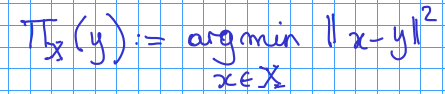

#### Naming guide

"variable"+ _A _B 

    A - length of vector as a power of 10 (10^4, 10^6)

    B - gradient method (e, f, c, b)
    
    
Example: k_4_e - iterations with n=10^4, using exact derivative

# 1. n = 10^4

## A) Exact gradient

In [33]:
n = 10**4
np.random.seed(288874)
x0 = np.random.random(n)
L = np.ones(n)     #lower bound (1)
U = np.ones(n) * 2 #upper bound (2)

x_seq_4_e, k_4_e, fk_4_e, t_4_e = descent(x0, L, U, grad_method='e')

print(f"Exact derivative for 10^4 --- Iteration: {k_4_e+1}, time:{t_4_e} s")

Exact derivative for 10^4 --- Iteration: 48, time:0.5868959426879883 s


## B) Forward differences gradient

In [6]:
n = 10**4
np.random.seed(288874)
x0 = np.random.random(n)
L = np.ones(n)     #lower bound (1)
U = np.ones(n) * 2 #upper bound (2)

x_seq_k_4_f = [] 
k_k_4_f = []
fk_k_4_f = []
t_k_4_f = []

for i in range(2, 13, 2):
    print(f"k: {i}")
    x_seq_i, k_i, fk_i, t_i = descent(x0, L, U, grad_method='f', grad_method_k=i)
    
    print(f"Iteration: {k_i+1}, time:{t_i} s \n")
    
    x_seq_k_4_f.append(x_seq_i)
    k_k_4_f.append(k_i)
    fk_k_4_f.append(fk_i)
    t_k_4_f.append(t_i)

k: 2
Iteration: 48, time:6.691483974456787 s 

k: 4
Iteration: 48, time:6.573555946350098 s 

k: 6
Iteration: 48, time:6.187804937362671 s 

k: 8
Iteration: 48, time:6.171245574951172 s 

k: 10
Iteration: 48, time:6.299541473388672 s 

k: 12
Iteration: 48, time:6.072954893112183 s 



# 2. n = 10^6

## A) Exact gradient

In [8]:
n = 10**6
np.random.seed(288874)
x0 = np.random.random(n)
L = np.ones(n)     #lower bound (1)
U = np.ones(n) * 2 #upper bound (2)

x_seq_6_e, k_6_e, fk_6_e, t_6_e = descent(x0, L, U, grad_method='e')

print(f"Exact derivative for 10^6 --- Iteration: {k_6_e+1}, time:{t_6_e} s")

Exact derivative for 10^6 --- Iteration: 48, time:46.902482748031616 s


## B) Forward differences gradient

In [4]:
n = 10**6
np.random.seed(288874)
x0 = np.random.random(n)
L = np.ones(n)     #lower bound (1)
U = np.ones(n) * 2 #upper bound (2)

x_seq_k_6_f = [] 
k_k_6_f = []
fk_k_6_f = []
t_k_6_f = []

for i in range(2, 9, 2):
    print(f"k: {i}")
    x_seq_i, k_i, fk_i, t_i = descent(x0, L, U, grad_method='f', grad_method_k=i)
    
    print(f"Iteration: {k_i+1}, time:{t_i} s \n")
    
    x_seq_k_6_f.append(x_seq_i)
    k_k_6_f.append(k_i)
    fk_k_6_f.append(fk_i)
    t_k_6_f.append(t_i)

k: 2
Iteration: 48, time:595.2214076519012 s 

k: 4
Iteration: 48, time:594.6810591220856 s 

k: 6
Iteration: 48, time:587.5145070552826 s 

k: 8
Iteration: 48, time:586.9224534034729 s 



In [5]:
for i in range(10, 13, 2):
    print(f"k: {i}")
    x_seq_i, k_i, fk_i, t_i = descent(x0, L, U, grad_method='f', grad_method_k=i)
    
    print(f"Iteration: {k_i+1}, time:{t_i} s \n")
    
    x_seq_k_6_f.append(x_seq_i)
    k_k_6_f.append(k_i)
    fk_k_6_f.append(fk_i)
    t_k_6_f.append(t_i)

k: 10
Iteration: 48, time:585.0535550117493 s 

k: 12
Iteration: 48, time:721.4772608280182 s 



In [13]:
def draw_time_comparison(first, second, title= ' '):
    fig, ax = plt.subplots(figsize = (10,5))
    plt.grid()

    fig.suptitle('Time comparison graph' + title, fontsize=20)
    ax = plt.plot(range(2, 13, 2), first, 'r-',linewidth=3)
    ax = plt.plot(range(2, 13, 2), second, 'b--',linewidth=3)
    plt.legend(['n=10^4', 'n=10^6'], loc ="upper left", prop={'size': 12})
    plt.xlabel('k parameter of finite difference ', fontsize=20)
    plt.ylabel('Iteration time, seconds', fontsize=20)
    plt.tick_params(axis='x', labelsize=20) 
    plt.tick_params(axis='y', labelsize=20)
    
    fig.savefig('Time_'+title+'.eps', format='eps')

def draw_iteration_comparison(first, second, title= ' '):
    fig, ax = plt.subplots(figsize = (10,5))
    plt.grid()

    fig.suptitle('# of iterations comparison graph ' + title, fontsize=20)
    ax = plt.plot(range(2, 13, 2), first, 'r-',linewidth=3)
    ax = plt.plot(range(2, 13, 2), second, 'b--',linewidth=3)
    
    plt.legend(['n=10^4', 'n=10^6'], loc ="upper left", prop={'size': 12})
    plt.xlabel('k parameter of finite difference', fontsize=20)
    plt.ylabel('Iterations', fontsize=20)
    plt.tick_params(axis='x', labelsize=20) 
    plt.tick_params(axis='y', labelsize=20)
    
    fig.savefig('Iter_'+title+'.eps', format='eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


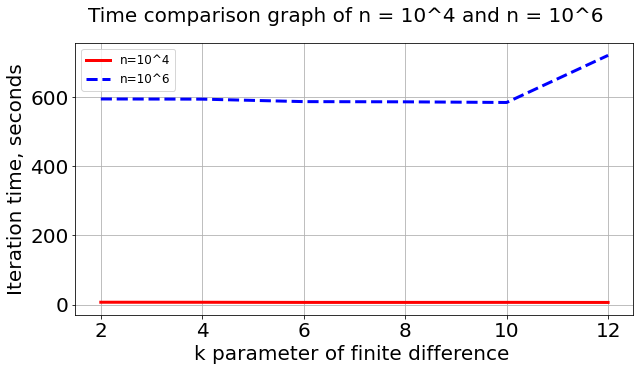

In [15]:
draw_time_comparison(t_k_4_f, t_k_6_f, ' of n = 10^4 and n = 10^6')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


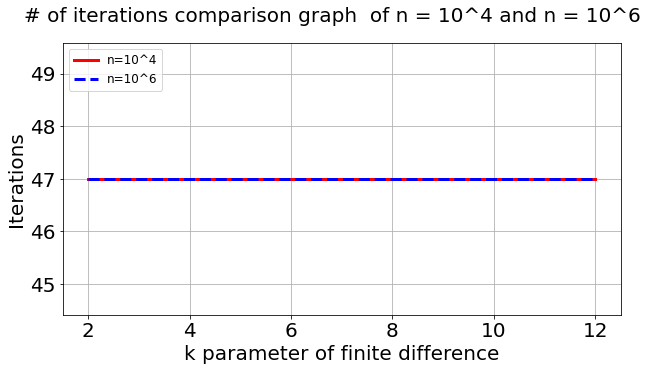

In [12]:
draw_iteration_comparison(k_k_4_f, k_k_6_f, ' of n = 10^4 and n = 10^6')